In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the combined dataset
df = pd.read_csv('sabrina_reddit_combined.csv')

# Initialize cleaner
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # emojis & non-ASCII
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Drop full duplicates and rows with blank/NaN comment_body or post_title
df = df.drop_duplicates()
df = df.dropna(subset=['comment_body', 'post_title'])
df = df[(df['comment_body'].str.strip() != '') & (df['post_title'].str.strip() != '')]

# Apply cleaning to both columns
df['cleaned_comment'] = df['comment_body'].apply(clean_text)
df['cleaned_title'] = df['post_title'].apply(clean_text)

# Drop rows where both cleaned versions are blank
df = df[(df['cleaned_comment'].str.strip() != '') | (df['cleaned_title'].str.strip() != '')]

# Preview
print(df[['post_title', 'comment_body', 'cleaned_title', 'cleaned_comment']].head())

# Save cleaned version
df.to_csv("sabrina_reddit_combined_cleaned.csv", index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                  post_title  \
0  2023 Carolina Herrera Fashion Show in Rio   
1  2023 Carolina Herrera Fashion Show in Rio   
2  2023 Carolina Herrera Fashion Show in Rio   
3  2023 Carolina Herrera Fashion Show in Rio   
4  2023 Carolina Herrera Fashion Show in Rio   

                                    comment_body  \
0                                    Very Cute 😍   
1                                 Maravilhosa 🇧🇷   
2  Has a bit of a Riley Reid look with that hair   
3                                     Disrespect   
4                                        Why so?   

                       cleaned_title           cleaned_comment  
0  carolina herrera fashion show rio                      cute  
1  carolina herrera fashion show rio               maravilhosa  
2  carolina herrera fashion show rio  bit riley reid look hair  
3  carolina herrera fashion show rio                disrespect  
4  carolina herrera fashion show rio                            


In [2]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Ensure VADER is downloaded
nltk.download('vader_lexicon')

# Load cleaned data
df = pd.read_csv('sabrina_reddit_combined_cleaned.csv')

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Apply VADER to cleaned_text
# Apply VADER to cleaned_comment, safely converting non-strings
df['vader_score'] = df['cleaned_comment'].astype(str).apply(lambda x: vader.polarity_scores(x)['compound'])

#df['vader_score'] = df['cleaned_comment'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Classify sentiment
def classify(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['vader_score'].apply(classify)

# Display sample
df[['comment_body', 'cleaned_comment', 'vader_score', 'sentiment']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,comment_body,cleaned_comment,vader_score,sentiment
0,Very Cute 😍,cute,0.4588,positive
1,Maravilhosa 🇧🇷,maravilhosa,0.0000,neutral
2,Has a bit of a Riley Reid look with that hair,bit riley reid look hair,0.0000,neutral
3,Disrespect,disrespect,-0.4215,negative
4,Why so?,NaN,0.0000,neutral


In [3]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


# Load cleaned data
df = pd.read_csv('sabrina_reddit_combined_cleaned.csv')

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# === Comment Sentiment Analysis ===
df['vader_score'] = df['cleaned_comment'].astype(str).apply(lambda x: vader.polarity_scores(x)['compound'])

def classify(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['vader_score'].apply(classify)

# === Title Sentiment Analysis ===
df['post_title'] = df['post_title'].fillna('')
df['cleaned_title'] = df['post_title'].astype(str).str.lower().str.replace(r'[^\x00-\x7F]+', ' ', regex=True)
df['title_vader_score'] = df['cleaned_title'].apply(lambda x: vader.polarity_scores(x)['compound'])
df['title_sentiment'] = df['title_vader_score'].apply(classify)

# Display sample
df[['post_title', 'comment_body', 'cleaned_comment', 'vader_score', 'sentiment', 'title_vader_score', 'title_sentiment']].head()


,post_title,comment_body,cleaned_comment,vader_score,sentiment,title_vader_score,title_sentiment
0,2023 Carolina Herrera Fashion Show in Rio,Very Cute 😍,cute,0.4588,positive,0.0,neutral
1,2023 Carolina Herrera Fashion Show in Rio,Maravilhosa 🇧🇷,maravilhosa,0.0000,neutral,0.0,neutral
2,2023 Carolina Herrera Fashion Show in Rio,Has a bit of a Riley Reid look with that hair,bit riley reid look hair,0.0000,neutral,0.0,neutral
3,2023 Carolina Herrera Fashion Show in Rio,Disrespect,disrespect,-0.4215,negative,0.0,neutral
4,2023 Carolina Herrera Fashion Show in Rio,Why so?,NaN,0.0000,neutral,0.0,neutral


In [4]:
pd.read_csv("sabrina_reddit_combined_cleaned.csv", sep=None, engine='python').head()


,subreddit,post_id,post_title,post_author,post_score,post_created_utc,post_created_utc_readable,post_num_comments,post_selftext,post_flair,comment_id,comment_author,comment_body,comment_score,comment_created_utc,comment_created_utc_readable,comment_flair,cleaned_comment,cleaned_title
0,SabrinaCarpenter,13z5llz,2023 Carolina Herrera Fashion Show in Rio,deleted,427,1.685780e+09,2023-06-03 08:11:00,6,NaN,NaN,jms16zy,PeytonListLover,Very Cute 😍,2,1.685822e+09,2023-06-03 19:45:47,NaN,cute,carolina herrera fashion show rio
1,SabrinaCarpenter,13z5llz,2023 Carolina Herrera Fashion Show in Rio,deleted,427,1.685780e+09,2023-06-03 08:11:00,6,NaN,NaN,jmqdcbf,Maleficent-Whole-609,Maravilhosa 🇧🇷,1,1.685794e+09,2023-06-03 12:04:04,NaN,maravilhosa,carolina herrera fashion show rio
2,SabrinaCarpenter,13z5llz,2023 Carolina Herrera Fashion Show in Rio,deleted,427,1.685780e+09,2023-06-03 08:11:00,6,NaN,NaN,jmrj8d7,throw_it_oll_away,Has a bit of a Riley Reid look with that hair,1,1.685814e+09,2023-06-03 17:32:47,NaN,bit riley reid look hair,carolina herrera fashion show rio
3,SabrinaCarpenter,13z5llz,2023 Carolina Herrera Fashion Show in Rio,deleted,427,1.685780e+09,2023-06-03 08:11:00,6,NaN,NaN,jo9sq6j,trustnun74,Disrespect,1,1.686863e+09,2023-06-15 20:59:50,NaN,disrespect,carolina herrera fashion show rio
4,SabrinaCarpenter,13z5llz,2023 Carolina Herrera Fashion Show in Rio,deleted,427,1.685780e+09,2023-06-03 08:11:00,6,NaN,NaN,joqbjv9,throw_it_oll_away,Why so?,1,1.687197e+09,2023-06-19 17:55:20,NaN,NaN,carolina herrera fashion show rio


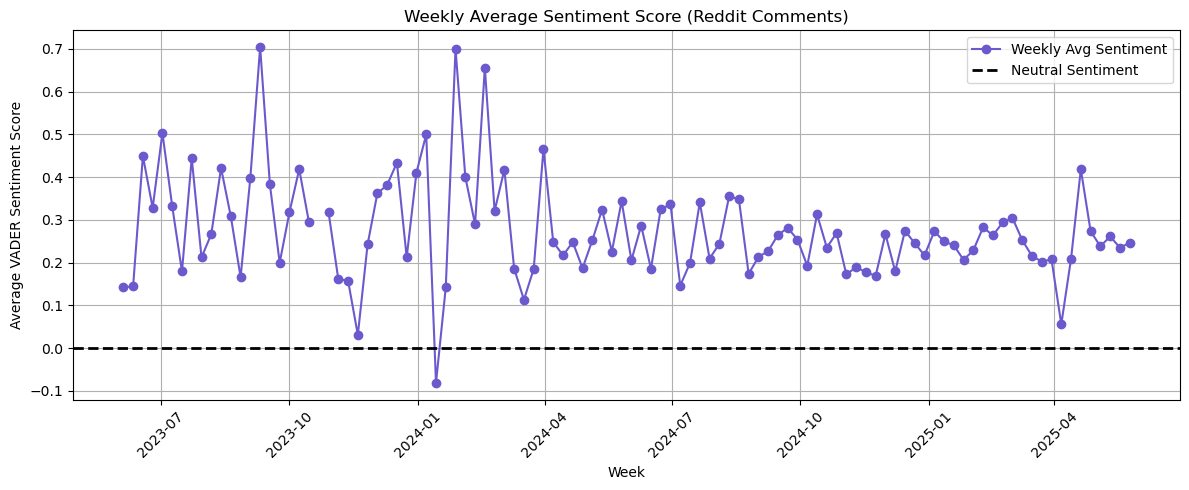

In [5]:


import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt



# Load cleaned data
df = pd.read_csv("sabrina_reddit_combined_cleaned.csv")

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Drop rows with empty cleaned text
df = df[df['cleaned_comment'].notnull() & (df['cleaned_comment'].str.strip() != '')]

# Apply VADER sentiment scoring
df['vader_score'] = df['cleaned_comment'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Convert date column
df['comment_created_utc_readable'] = pd.to_datetime(df['comment_created_utc_readable'], errors='coerce')
df = df.dropna(subset=['comment_created_utc_readable'])

# Set datetime as index
df.set_index('comment_created_utc_readable', inplace=True)

# Resample to weekly average sentiment
weekly_sentiment = df['vader_score'].resample('W').mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(weekly_sentiment['comment_created_utc_readable'], weekly_sentiment['vader_score'],
         marker='o', linestyle='-', color='slateblue', label='Weekly Avg Sentiment')

# Add bold horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=2, linestyle='--', label='Neutral Sentiment')

plt.title("Weekly Average Sentiment Score (Reddit Comments)")
plt.xlabel("Week")
plt.ylabel("Average VADER Sentiment Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined cleaned file
df = pd.read_csv("sabrina_reddit_combined_cleaned.csv")

# Convert timestamps
df['post_created_utc_readable'] = pd.to_datetime(df['post_created_utc_readable'], errors='coerce')
df['comment_created_utc_readable'] = pd.to_datetime(df['comment_created_utc_readable'], errors='coerce')

# DEBUG: Check how many non-null entries exist
print("Number of posts with date:", df['post_created_utc_readable'].notnull().sum())
print("Number of comments with date:", df['comment_created_utc_readable'].notnull().sum())

# Extract year columns
df['post_year'] = df['post_created_utc_readable'].dt.year
df['comment_year'] = df['comment_created_utc_readable'].dt.year

# DEBUG: Preview counts
print("Posts per year:\n", df['post_year'].value_counts().sort_index())
print("Comments per year:\n", df['comment_year'].value_counts().sort_index())

# Aggregate counts
post_counts = df['post_year'].value_counts().sort_index()
comment_counts = df['comment_year'].value_counts().sort_index()

# Reindex both series to ensure same X-axis
all_years = sorted(set(post_counts.index).union(set(comment_counts.index)))
post_counts = post_counts.reindex(all_years, fill_value=0)
comment_counts = comment_counts.reindex(all_years, fill_value=0)



✅ Number of posts with date: 38805
✅ Number of comments with date: 38805
📊 Posts per year:
 post_year
2023      402
2024     3684
2025    34719
Name: count, dtype: int64
📊 Comments per year:
 comment_year
2023      394
2024     3667
2025    34744
Name: count, dtype: int64


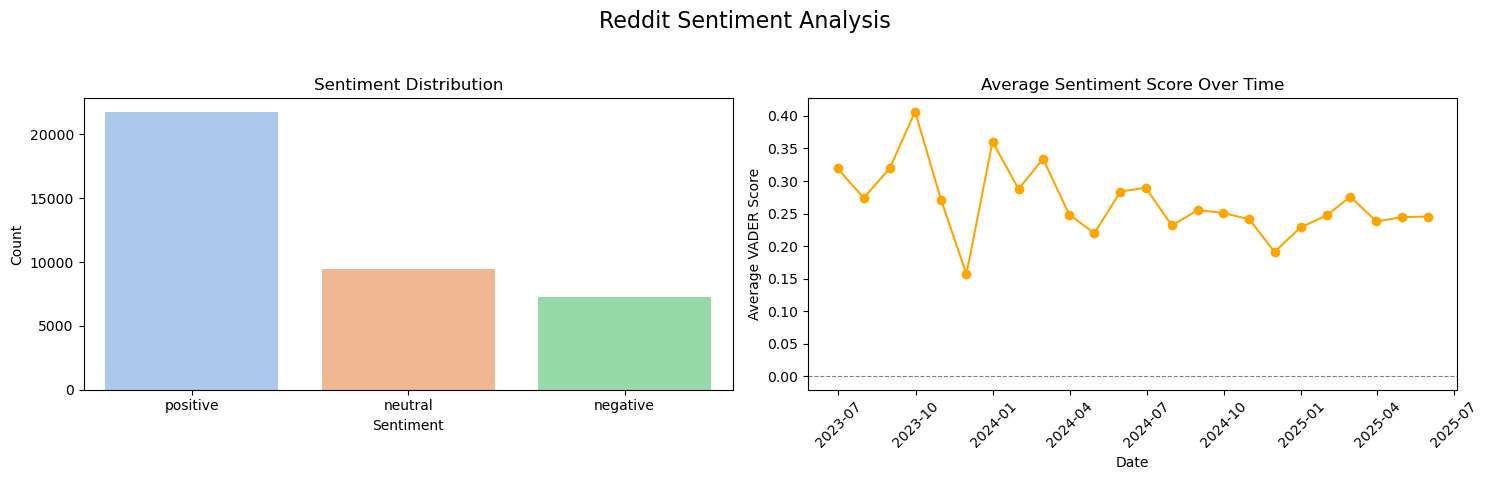

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Load cleaned data
df = pd.read_csv("sabrina_reddit_combined_cleaned.csv")

# Filter valid comments
df = df[df['cleaned_comment'].notnull() & (df['cleaned_comment'].str.strip() != '')]

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Compute VADER compound score
df['vader_score'] = df['cleaned_comment'].apply(lambda x: vader.polarity_scores(str(x))['compound'])

# Classify sentiment labels
def classify(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['vader_score'].apply(classify)

# Convert and clean date
df['comment_created_utc_readable'] = pd.to_datetime(df['comment_created_utc_readable'], errors='coerce')
df = df.dropna(subset=['comment_created_utc_readable'])

# Set datetime index for resampling
df.set_index('comment_created_utc_readable', inplace=True)

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Reddit Sentiment Analysis", fontsize=16)

# 1. Sentiment Distribution
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='pastel', ax=axes[0])
axes[0].set_title("Sentiment Distribution")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")

# 2. Average Sentiment Score Over Time (monthly)
monthly_avg = df['vader_score'].resample('M').mean()

axes[1].plot(monthly_avg.index, monthly_avg.values, marker='o', color='orange')
axes[1].axhline(y=0, linestyle='--', color='gray', linewidth=0.8)
axes[1].set_title("Average Sentiment Score Over Time")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Average VADER Score")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [8]:
import pandas as pd
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Load cleaned dataset
df = pd.read_csv("sabrina_reddit_combined_cleaned.csv")

# Filter for non-empty cleaned_comment column
df = df[df['cleaned_comment'].notnull() & (df['cleaned_comment'].str.strip() != '')]

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
texts = df['cleaned_comment'].apply(word_tokenize).tolist()
texts = [[word for word in doc if word not in stop_words and len(word) > 2] for doc in texts]

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    random_state=42,
    passes=15,
    alpha='auto',
    per_word_topics=True
)

# Display topics
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"🔹 Topic {idx + 1}: {topic}")


🔹 Topic 1: 0.022*"song" + 0.019*"like" + 0.013*"album" + 0.010*"music" + 0.010*"think" + 0.010*"really" + 0.010*"one" + 0.008*"love" + 0.008*"good" + 0.008*"year"
🔹 Topic 2: 0.026*"bot" + 0.023*"please" + 0.021*"link" + 0.020*"message" + 0.019*"send" + 0.018*"confidence" + 0.017*"music" + 0.013*"cant" + 0.013*"youtube" + 0.013*"question"
🔹 Topic 3: 0.014*"people" + 0.012*"like" + 0.008*"get" + 0.006*"going" + 0.006*"want" + 0.005*"one" + 0.005*"know" + 0.004*"someone" + 0.004*"also" + 0.004*"right"


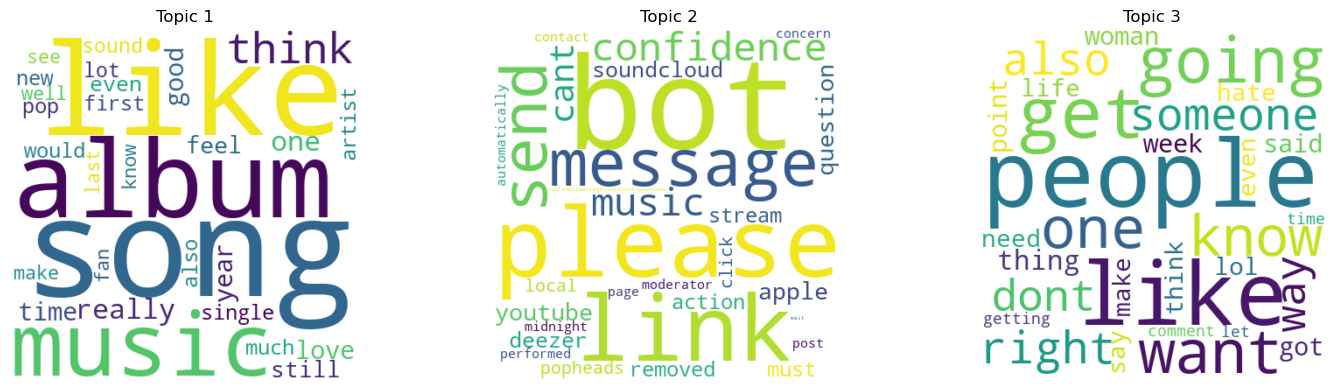

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the actual number of topics from the model
num_topics = lda_model.num_topics

# Plot word clouds for each topic
fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 4))
if num_topics == 1:
    axes = [axes]  # Make it iterable if there's only one topic

for i in range(num_topics):
    topic_words = dict(lda_model.show_topic(i, topn=30))
    wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(topic_words)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Topic {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
